## Balanceamento "Random Under Sampler"

Técnica utilizada para lidar com dados desbalanceados em que o número de exemplos da calsse majoritária é reduzido para igualar ou aproximar o número de exemplos da classe minoritária.

### Bibliotecas

In [1]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    def cor_linhas(row):
        if row.name % 2 == 0:
            return ['background-color: #ffffff'] * len(row)
        else:
            return ['background-color: #f9f9f9'] * len(row)
    
    return (
        df.style.apply(cor_linhas, axis=1)  # Aplica cor alternada às linhas
        .set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},  # Azul abaixo do nome das colunas
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '300px')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        )
        .set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        )
        .set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        )
        .format(
            precision=casas_decimais  
        )
    )

### Base de dados

In [2]:
#Leitura da base de dados

object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

#Selecionar apenas as variáveis textuais
df_eventos = df_eventos[["Status", "DH_Descricao", "DM_Descricao", "DA_Descricao"]]

#Atribuir valor 0 ao status "Reconhecido" e 1 ao status "Não reconhecido"
df_eventos['Status'] = df_eventos['Status'].map({'Reconhecido': 0, 'Não reconhecido': 1})

#Visualizar amostra de dados
estilo_tabelas(df_eventos.tail(5))

,Status,DH_Descricao,DM_Descricao,DA_Descricao
26253,0,A seca tem causado interrupções no fornecimento de água potável para a população dos núcleos urbanos e limitações severas no consumo de água nos domicílios situados na zona rural que precisam aguardar um tempo elevado para que a água acumule em cisterna em volume que seja possível bombear. _x000D_ _x000D_,nan,Redução dos cursos de água e pastagem provocado pela seca.
26254,0,"Conforme laudo da assistência social, o desastre Tempestade Local/Convectiva - Vendaval atingiu o município em todo o seu território urbano e rural, afetando diretamente 1.180 famílias, aproximadamente 4.716 pessoas, desse total, aproximadamente 30 pessoas ficaram desalojadas. Ainda dentro desse número de famílias 30 famílias foram diretamente afetadas, sendo aproximadamente 120 pessoas encontram-se em vulnerabilidade social. Todos os afetados tiveram danos em suas residências, em telhados, em muitas delas perdendo móveis, roupas e alimentos. Estradas no interior que ficaram sem condições seguras de trafegabilidade e/ou bloqueadas, conforme constatado pela engenharia. A tempestade que atingiu o município afetou as famílias também com a falta de energia elétrica e consequentemente de água, sendo restabelecida em todo o território do município somente no dia 02 de Janeiro.","Conforme laudo da engenharia o evento vendaval causou danos em aproximadamente 30 unidades habitacionais, 01 instalação pública de saúde, uma de ensino e ainda nas estradas rurais do município.",Os danos ambientais recorrem da grande quantidade de lixo produzido pela quebra das telhas de fibrocimento e queda de árvores.
26255,0,"Conforme laudo da assistência social, 20 famílias, 80 pessoas ficaram desalojadas devido destelhamento das suas residências, sendo que três moradias teve todo telhado arrancado, com tesouras e forro. No total foram 276 unidades habitacionais danificadas conforme laudo da engenharia. Ainda conforme laudo da Emater em anexo, houve prejuízos na pecuária que chegam ao valor de R$ 132.000,00.","Conforme laudo da engenharia foram danificadas 276 unidades habitacionais, 07 instalações públicas de ensino sofreram destelhamento devidos aos fortes ventos.",Os danos ambientais recorrem da grande quantidade de lixo produzido pelas quebra das telhas de fibrocimento e quedas de inúmeras árvores.
26256,0,"As pessoas atingidas, tiveram os telhados de suas residências danificados, moveis molhados, sendo necessário cobrir com lonas, totalizando num total de 300 pessoas atingidas diretamente, de acordo com o laudo da assistência social.","De acordo com o laudo da engenharia civil, houve um total de 75 unidades habitacionais atingidas, totalizando um dano estimado de R$120.583,50. Além disso, foi registrado danos causados em prédios públicos, como postos de saúde, escolas, secretarias, totalizando um valor estimado de R$106.834,65.",nan
26257,0,"Toda a população do Município foi afetada direta ou indiretamente pelo evento adverso do dia 29 de dezembro de 2023, devido aos fortes ventos em todo teritório do Município de Ubiretama, que causaram vários destelhamentos em residências e prédios públicos, queda de galhos e árvores sobre as vias municipais, assim dificultando a locomoção das pessoas, bem como interrupçao de fornecimento de energia elétrica, sendo que todo município de Ubiretama está sem energia elétrica até o momento, o que pode perdurar por vários dias inclusive.","Várias residências afetadas, causando um valor aproximado de R$ 10.000,00(dez mil reais), e a quadra de futebol society, que foi teve a cobertura totalmente destruída, em razão dos fortes ventos, causando um prejuízo aproximado de R$ 250.000,00(duzentos e cinquenta mil reais), de acordo com o Relatório do Engenheiro Civil.",nan


### Balanceamento das classes

#### Under Sampler

In [3]:
X = df_eventos.loc[:, ['DH_Descricao', 'DM_Descricao', 'DA_Descricao']]
y = df_eventos['Status']

# Instanciar RandomUnderSampler
under = RandomUnderSampler(random_state=0)

# Treinar e fazer RandomUnderSampler nod dados
X_balanceadounder, y_balanceadounder = under.fit_resample(X, y)

# Mostrar as dimensões de X e y
print('Dimensões de X_resampled = ', X_balanceadounder.shape)
print('Dimensões de y_resampled = ', y_balanceadounder.shape)

df_eventos_undersampler = pd.DataFrame(X_balanceadounder)
df_eventos_undersampler['Status']= y_balanceadounder

Dimensões de X_resampled =  (4774, 3)
Dimensões de y_resampled =  (4774,)


In [4]:
df_DH_Descricao_undersampler = df_eventos_undersampler[['Status', 'DH_Descricao']].dropna(subset=['Status', 'DH_Descricao'])

df_DM_Descricao_undersampler = df_eventos_undersampler[['Status', 'DM_Descricao']].dropna(subset=['Status', 'DM_Descricao'])

df_DA_Descricao_undersampler = df_eventos_undersampler[['Status', 'DA_Descricao']].dropna(subset=['Status', 'DA_Descricao'])

print('Dimensões das bases de dados (Balanceado com under sampler): \n')
print('Descrição dos danos humanos:', df_DH_Descricao_undersampler.shape)
print('Descrição dos danos materiais:',df_DM_Descricao_undersampler.shape)
print('Descrição dos danos ambientais:',df_DA_Descricao_undersampler.shape)

print('\n Novo balanceamento das bases de dados (Balanceado com under sampler): \n')
print('Balanceamento em "danos humanos:', df_DH_Descricao_undersampler['Status'].value_counts())
print('Balanceamento em "danos materiais:', df_DM_Descricao_undersampler['Status'].value_counts())
print('Balanceamento em "danos ambientais:', df_DA_Descricao_undersampler['Status'].value_counts())

Dimensões das bases de dados (Balanceado com under sampler): 

Descrição dos danos humanos: (3659, 2)
Descrição dos danos materiais: (2762, 2)
Descrição dos danos ambientais: (2806, 2)

 Novo balanceamento das bases de dados (Balanceado com under sampler): 

Balanceamento em "danos humanos: Status
1    1892
0    1767
Name: count, dtype: int64
Balanceamento em "danos materiais: Status
1    1575
0    1187
Name: count, dtype: int64
Balanceamento em "danos ambientais: Status
0    1447
1    1359
Name: count, dtype: int64


### Modelo para "Descrição de danos humanos"

In [5]:
#Treino e teste
X_train_humanos_under, X_test_humanos_under, y_train_humanos_under, y_test_humanos_under = train_test_split(df_DH_Descricao_undersampler['DH_Descricao'], df_DH_Descricao_undersampler['Status'], test_size=0.2, random_state=1)

# Instanciamento do transform CountVectorizer
tfidf_vectorizer_humanos_under = TfidfVectorizer()

# Tokenização e criação do vocabulário

tfidf_vectorizer_humanos_under.fit(X_train_humanos_under)

#Treinamento e classificador

pipeline_humanos_under = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss')),
])

classificador_humanos_under = pipeline_humanos_under.fit(X_train_humanos_under, y_train_humanos_under)

predicted_humanos_under = classificador_humanos_under.predict(X_test_humanos_under)

classification_report_humanos_under = metrics.classification_report(y_test_humanos_under, predicted_humanos_under, digits=6, target_names=['Reconhecido', 'Não reconhecido'])

print('Classification report para danos humanos (balanceamento RandomUnderSampler: \n')
print(classification_report_humanos_under)

Classification report para danos humanos (balanceamento RandomUnderSampler: 

                 precision    recall  f1-score   support

    Reconhecido   0.710526  0.654987  0.681627       371
Não reconhecido   0.671795  0.725762  0.697736       361

       accuracy                       0.689891       732
      macro avg   0.691161  0.690374  0.689682       732
   weighted avg   0.691425  0.689891  0.689572       732



### Modelo para "Descrição de danos materiais"

In [6]:
#Treino e teste
X_train_materiais_under, X_test_materiais_under, y_train_materiais_under, y_test_materiais_under = train_test_split(df_DM_Descricao_undersampler['DM_Descricao'], df_DM_Descricao_undersampler['Status'], test_size=0.2, random_state=1)

# Instanciamento do transform CountVectorizer
tfidf_vectorizer_materiais_under = TfidfVectorizer()

# Tokenização e criação do vocabulário

tfidf_vectorizer_materiais_under.fit(X_train_materiais_under)

#Treinamento e classificador

pipeline_materiais_under = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss')),
])

classificador_materiais_under = pipeline_materiais_under.fit(X_train_materiais_under, y_train_materiais_under)

predicted_materiais_under = classificador_materiais_under.predict(X_test_materiais_under)

classification_report_materiais_under = metrics.classification_report(y_test_materiais_under, predicted_materiais_under, digits=6, target_names=['Reconhecido', 'Não reconhecido'])

print('Classification report para danos materiais (balanceamento RandomUnderSampler: \n')
print(classification_report_materiais_under)

Classification report para danos materiais (balanceamento RandomUnderSampler: 

                 precision    recall  f1-score   support

    Reconhecido   0.549763  0.517857  0.533333       224
Não reconhecido   0.684211  0.711246  0.697466       329

       accuracy                       0.632911       553
      macro avg   0.616987  0.614552  0.615400       553
   weighted avg   0.629751  0.632911  0.630982       553



### Modelo para "Descrição de danos ambientais"

In [7]:
#Treino e teste
X_train_ambientais_under, X_test_ambientais_under, y_train_ambientais_under, y_test_ambientais_under = train_test_split(df_DA_Descricao_undersampler['DA_Descricao'], df_DA_Descricao_undersampler['Status'], test_size=0.2, random_state=1)

# Instanciamento do transform CountVectorizer
tfidf_vectorizer_ambientais_under = TfidfVectorizer()

# Tokenização e criação do vocabulário

tfidf_vectorizer_ambientais_under.fit(X_train_ambientais_under)

#Treinamento e classificador

pipeline_ambientais_under = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(loss='log_loss')),
])

classificador_ambientais_under = pipeline_ambientais_under.fit(X_train_ambientais_under, y_train_ambientais_under)

predicted_ambientais_under = classificador_ambientais_under.predict(X_test_ambientais_under)

classification_report_ambientais_under = metrics.classification_report(y_test_materiais_under, predicted_materiais_under, digits=6, target_names=['Reconhecido', 'Não reconhecido'])

print('Classification report para danos ambientais (balanceamento RandomUnderSampler: \n')
print(classification_report_ambientais_under)

Classification report para danos ambientais (balanceamento RandomUnderSampler: 

                 precision    recall  f1-score   support

    Reconhecido   0.549763  0.517857  0.533333       224
Não reconhecido   0.684211  0.711246  0.697466       329

       accuracy                       0.632911       553
      macro avg   0.616987  0.614552  0.615400       553
   weighted avg   0.629751  0.632911  0.630982       553



### Comparação entre os modelos para danos humanos, materiais e ambientais

#### Métricas de classificação

In [8]:
# Classification report em dicionário
classification_report_ambiental_dict_under = metrics.classification_report(y_test_ambientais_under, predicted_ambientais_under, digits=6, target_names=['Reconhecido', 'Não reconhecido'], output_dict=True)
classification_report_materiais_dict_under = metrics.classification_report(y_test_materiais_under, predicted_materiais_under, digits=6, target_names=['Reconhecido', 'Não reconhecido'], output_dict=True)
classification_report_humanos_dict_under = metrics.classification_report(y_test_humanos_under, predicted_humanos_under, digits=6, target_names=['Reconhecido', 'Não reconhecido'], output_dict=True)

# DataFrame
df_ambiental_under = pd.DataFrame(classification_report_ambiental_dict_under).transpose()
df_materiais_under = pd.DataFrame(classification_report_materiais_dict_under).transpose()
df_humanos_under = pd.DataFrame(classification_report_humanos_dict_under).transpose()

df_ambiental_under.columns = [f"{col}_ambientais" for col in df_ambiental_under.columns]
df_materiais_under.columns = [f"{col}_materiais" for col in df_materiais_under.columns]
df_humanos_under.columns = [f"{col}_humanos" for col in df_humanos_under.columns]

df_comparativo_danos_under = pd.concat([df_ambiental_under, df_materiais_under, df_humanos_under], axis=1)

df_comparativo_danos_under

,precision_ambientais,recall_ambientais,f1-score_ambientais,support_ambientais,precision_materiais,recall_materiais,f1-score_materiais,support_materiais,precision_humanos,recall_humanos,f1-score_humanos,support_humanos
Reconhecido,0.700000,0.750865,0.724541,289.000000,0.549763,0.517857,0.533333,224.000000,0.710526,0.654987,0.681627,371.000000
Não reconhecido,0.714286,0.659341,0.685714,273.000000,0.684211,0.711246,0.697466,329.000000,0.671795,0.725762,0.697736,361.000000
accuracy,0.706406,0.706406,0.706406,0.706406,0.632911,0.632911,0.632911,0.632911,0.689891,0.689891,0.689891,0.689891
macro avg,0.707143,0.705103,0.705128,562.000000,0.616987,0.614552,0.615400,553.000000,0.691161,0.690374,0.689682,732.000000
weighted avg,0.706940,0.706406,0.705680,562.000000,0.629751,0.632911,0.630982,553.000000,0.691425,0.689891,0.689572,732.000000


#### Matriz de confusão

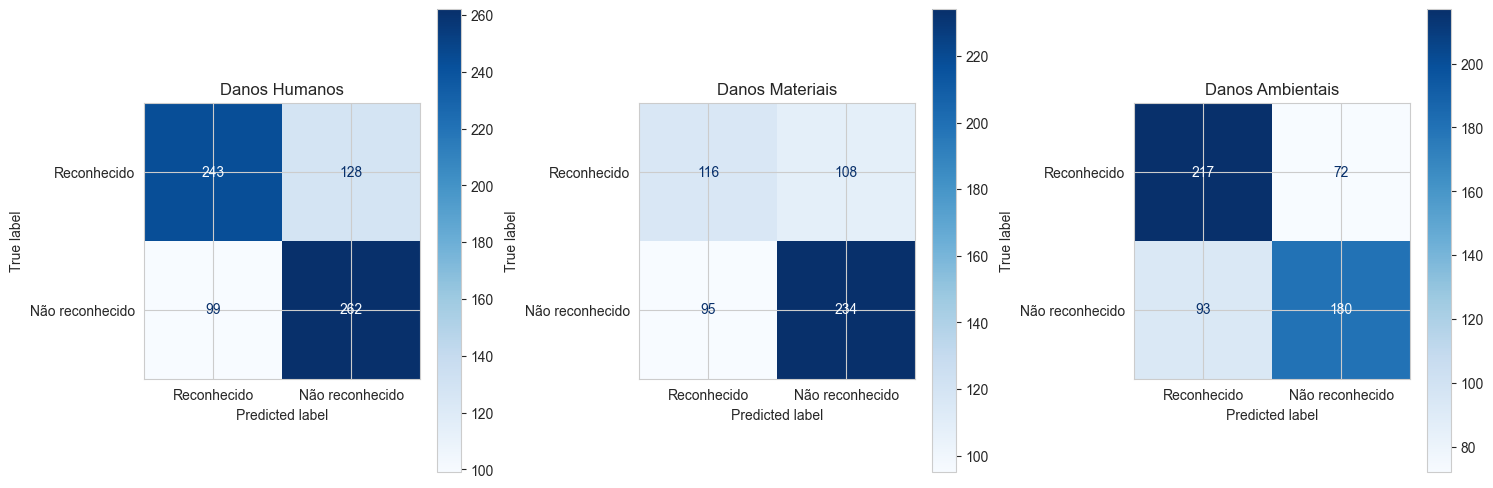

In [9]:
# Configurações
cmap = plt.cm.Blues
labels = ['Reconhecido', 'Não reconhecido']

# Subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

# Matriz de confusão para 'classificador_humanos'
ConfusionMatrixDisplay.from_estimator(classificador_humanos_under, X_test_humanos_under, y_test_humanos_under, 
                                      values_format='d', ax=axes[0], cmap=cmap, display_labels=labels)  # Especifica o subplot 1
axes[0].set_title('Danos Humanos')

# Matriz de confusão para 'classificador_materiais'
ConfusionMatrixDisplay.from_estimator(classificador_materiais_under, X_test_materiais_under, y_test_materiais_under, 
                                      values_format='d', ax=axes[1], cmap=cmap, display_labels=labels)  # Especifica o subplot 2
axes[1].set_title('Danos Materiais')

# Matriz de confusão para 'classificador_ambiental'
ConfusionMatrixDisplay.from_estimator(classificador_ambientais_under, X_test_ambientais_under, y_test_ambientais_under, 
                                      values_format='d', ax=axes[2], cmap=cmap, display_labels=labels)  # Especifica o subplot 3
axes[2].set_title('Danos Ambientais')

# Exibir o gráfico
plt.tight_layout()  # Ajusta os espaçamentos entre os gráficos para evitar sobreposição
plt.show()